# Tutorial 1. Controlling a basic experiment using MeasurementControl 

This tutorial covers basic usage of quantify focusing on running basic experiments using `MeasurementControl`. 
The `MeasurementControl` is the main `Instrument` in charge of running any experiment. It takes care of saving the data in a standardized format as well as live plotting of the data during the experiment. 
`quantify` makes a distinction between `soft`(ware) controlled measurements and `hard`(ware) controlled measurements. 

In a `soft` measurement `MeasurementControl` is in charge of the measurement loop and consecutively sets and gets datapoints. A `soft` measurement can be 1D, 2D or higher dimensional and also supports adaptive measurements in which the datapoints are determined during the measurement loop. 

In a `hard` measurement the hardware (such as an AWG) is in charge of the measurement loop. In this case, the datapoints to be acquired are determined before the experiment starts and are precompiled into the hardware which is then armed and starts acquisition. In a `hard` measurement `MeasurementControl` does not take care of the measurement loop but still takes care of the data storage and live plotting of the experiment. 

This tutorial is structured as follows. 
In the first section we use a 1D `soft`(ware) controlled loop to explain the flow of a basic experiment. We start by setting up a noisy cosine model to serve as our mock setup and then use the `MC` to measure this. We then perform basic (manual) analysis on the data from this experiment. We show how to find and load a dataset, perform a basic fit, and store the results. 

In [1]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
from qcodes import ManualParameter, Parameter
%matplotlib inline

In [2]:
from quantify.measurement import MeasurementControl
from quantify.measurement.control import Settable, Gettable
import quantify.visualization.pyqt_plotmon as pqm

In [3]:
MC = MeasurementControl('MC')
plotmon = pqm.PlotMonitor_pyqt('plotmon')
MC.instr_plotmon(plotmon.name)

In [4]:
MC.instr_plotmon.get_instr().tuid()

'latest'

## A 1D soft(ware) controlled loop

### Define a simple model 
We start by defining a simple model to mock our experiment setup. We will be generating a cosine with some normally distributed noise added on top of it. 

In [5]:
from time import sleep

In [6]:
def cos_func(t, amplitude, frequency, phase, offset):
    """A simple cosine function"""
    return amplitude * np.cos(2 * np.pi * frequency * t + phase) + offset

# Parameters are created to emulate a system being measured 
amp = ManualParameter('amp', initial_value=1, unit='V', label='Amplitude')
freq = ManualParameter('freq', initial_value=.5, unit='Hz', label='Frequency')
t = ManualParameter('t', initial_value=1, unit='s', label='Time')
phi = ManualParameter('phi', initial_value=0, unit='Rad', label='Phase')

# we add in some noise to make the fitting example later on more interesting
noise_level = ManualParameter('noise_level', initial_value=0.05, unit='V', label='Noise level')

acq_delay = ManualParameter('acq_delay', initial_value=.1, unit='s')

def cosine_model():
    sleep(acq_delay())
    return cos_func(t(), amp(), freq(), phase=phi(), offset=0) +np.random.randn()*noise_level()

# We wrap our function in a Parameter to be able to give 
sig = Parameter(name='sig', label='Signal level', unit='V', get_cmd=cosine_model)

In [7]:
acq_delay(0.0) # by setting this to a non-zero value we can see the live plotting in action. 

### Running the experiment

The complete experiment is defined in just 4 lines of code. We specify what parameter we want to set, time `t` in this case, what points to measure at, and what parameter to measure. 
We then tell the MeasurementControl `MC` to run which will return an `xarray:Dataset` object. 

We use the `Settable` and `Gettable` helper classes to ensure our parameters contain the correct attributes.

In [8]:
MC.settables(Settable(t))
MC.setpoints(np.linspace(0, 5, 50))
MC.gettables(Gettable(sig))
dset = MC.run('Cosine test')


 100% completed 	elapsed time: 0.7s 	time left: 0.0s


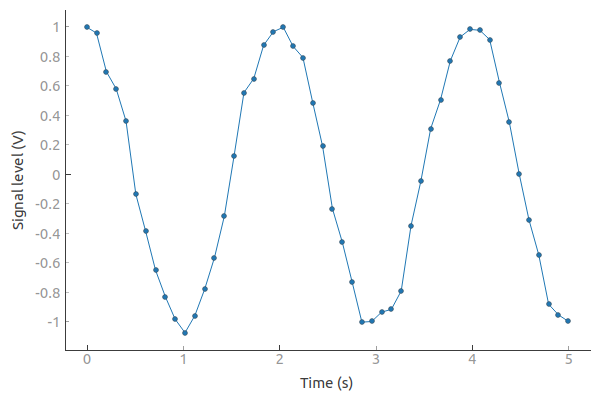

In [9]:
plotmon.main_QtPlot

In [10]:
dset.attrs['tuid']

'20200918-115107-883-0ca86b'

In [11]:
dset


<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
    y0       (dim_0) float64 0.9966 0.9562 0.6966 ... -0.8823 -0.9543 -0.9983
Attributes:
    tuid:     20200918-115107-883-0ca86b
    name:     Cosine test
    2D-grid:  False

We can play with some live plotting options to see how the MC behaves when changing the update interval. 

In [12]:
# By default the MC updates the datafile and live plot every 0.1 seconds to reduce overhead. 
# the total overhead is ~0.05s per update
MC.update_interval(0.01) # Setting it even to 0.01 makes a dramatic difference, try it out!

In [13]:
MC.settables(Settable(t))
MC.setpoints(np.linspace(0, 50, 1000))
MC.gettables(Gettable(sig))
dset = MC.run('Many points live plot test')

 100% completed 	elapsed time: 2.8s 	time left: 0.0s


In [14]:
noise_level(0) #let's disable noise from here on to get prettier figures

### Analyzing the experiment

#### Loading the data
The `Dataset` contains all the information required to perform basic analysis of the experiment and information on where the data is stored. 
We can alternatively load the dataset from disk based on it's `tuid`, a timestamp-based unique identifier. If you do not know the tuid of the experiment you can find the latest tuid containing a certain string in the experiment name using `quantify.data_handling.get_latest_tuid`. See the data storage documentation for more details on the folder structure and files contained in the data directory. 



In [15]:
from quantify.data.handling import load_dataset, get_latest_tuid

# here we look for the latest datafile in the datadirectory named "Cosine test"
# note that this is not he last dataset but one dataset earlier
tuid = get_latest_tuid('Cosine test') 
print('tuid: {}'.format(tuid))
dset = load_dataset(tuid)

dset

tuid: 20200918-115107-883-0ca86b


<xarray.Dataset>
Dimensions:  (dim_0: 50)
Dimensions without coordinates: dim_0
Data variables:
    x0       (dim_0) float64 0.0 0.102 0.2041 0.3061 ... 4.694 4.796 4.898 5.0
    y0       (dim_0) float64 0.9966 0.9562 0.6966 ... -0.8823 -0.9543 -0.9983
Attributes:
    tuid:     20200918-115107-883-0ca86b
    name:     Cosine test
    2D-grid:  0

#### Performing fits and extracting quantities of interest

We have used a cosine function "mock" an experiment, the goal of the experiment is to find the underlying parameters. 
We extract these parameters by performing a fit to a model, which coincidently, is based on the same cosine function. 
For fitting we recommend using the lmfit library.  See https://lmfit.github.io/lmfit-py/model.html on how to fit data to a custom model.

<AxesSubplot:title={'center':'Model(cos_func)'}, xlabel='t', ylabel='y'>

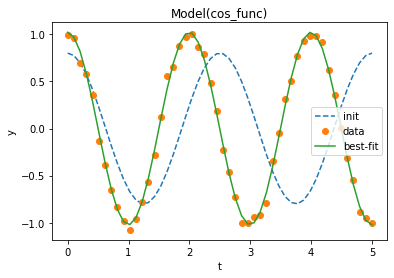

In [16]:
import lmfit
# we create a model based on our function
mod = lmfit.Model(cos_func)
# and specify initial guesses for each parameter
mod.set_param_hint('amplitude', value=.8, vary=True)
mod.set_param_hint('frequency', value=.4)
mod.set_param_hint('phase', value=0, vary=False)
mod.set_param_hint('offset', value=0, vary=False)
params = mod.make_params()
# and here we perform the fit. 
fit_res = mod.fit(dset['y0'].values, t=dset['x0'].values, params=params)


# It is possible to get a quick visualization of our fit using a build-in method of lmfit
fit_res.plot_fit(show_init=True)

In [17]:
fit_res.params

name,value,standard error,relative error,initial value,min,max,vary
amplitude,1.02109806,0.01013817,(0.99%),0.8,-inf,inf,True
frequency,0.50049207,5.6121e-04,(0.11%),0.4,-inf,inf,True
phase,0.00000000,0.00000000,,0,-inf,inf,False
offset,0.00000000,0.00000000,,0,-inf,inf,False


In [18]:
# And we can print an overview of the fitting results
print(fit_res.fit_report())

[[Model]]
    Model(cos_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 50
    # variables        = 2
    chi-square         = 0.12558302
    reduced chi-square = 0.00261631
    Akaike info crit   = -295.340563
    Bayesian info crit = -291.516517
[[Variables]]
    amplitude:  1.02109806 +/- 0.01013817 (0.99%) (init = 0.8)
    frequency:  0.50049207 +/- 5.6121e-04 (0.11%) (init = 0.4)
    phase:      0 (fixed)
    offset:     0 (fixed)


#### Plotting and saving the results of the analysis

In [19]:
# We include some visualization utilities in quantify
from quantify.visualization.SI_utilities import set_xlabel, set_ylabel

Text(0.5, 1.0, '20200918-115107-883-0ca86b\nCosine test')

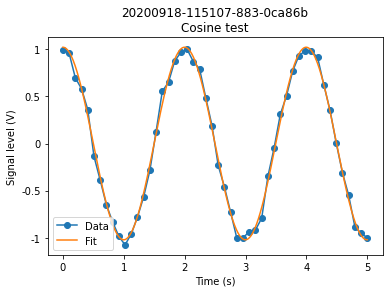

In [20]:
f, ax =plt.subplots()

ax.plot(dset['x0'], dset['y0'], marker='o', label='Data')
x_fit = np.linspace(dset['x0'][0], dset['x0'][-1], 1000)
y_fit = cos_func(t=x_fit, **fit_res.best_values)
ax.plot(x_fit, y_fit, label='Fit')
ax.legend()

set_xlabel(ax, dset['x0'].attrs['long_name'], dset['x0'].attrs['unit'])
set_ylabel(ax, dset['y0'].attrs['long_name'], dset['y0'].attrs['unit'])
ax.set_title('{}\n{}'.format(tuid, 'Cosine test'))

Now that we have analyzed our data and created a figure, we probably want to store the results of our analysis. 
We will want to store the figure and the results of the fit in the `experiment folder`. 


In [21]:
from os.path import join
from quantify.data.handling import create_exp_folder
exp_folder = create_exp_folder(dset.tuid, dset.name)

In [22]:
lmfit.model.save_modelresult(fit_res, join(exp_folder, 'fit_res.json'))
f.savefig(join(exp_folder, 'Cosine fit.png'), dpi=300, bbox_inches='tight')

## A 2D soft(ware) controlled loop

It is often desired to measure heatmaps (2D grids) of some parameter. 
This can be done by specifying two set parameters. 
The setpoints of the grid can be specified in two ways. 

### Method 1, a quick grid. 

In [23]:
MC.update_interval(.1)

In [24]:
times = np.linspace(0, 5, 500)
amps = np.linspace(-1, 1, 31)

MC.settables([Settable(t), Settable(amp)])
MC.setpoints_grid([times, amps])
MC.gettables(Gettable(sig))
dset = MC.run('2D Cosine test')

 100% completed 	elapsed time: 15.6s 	time left: 0.0ss


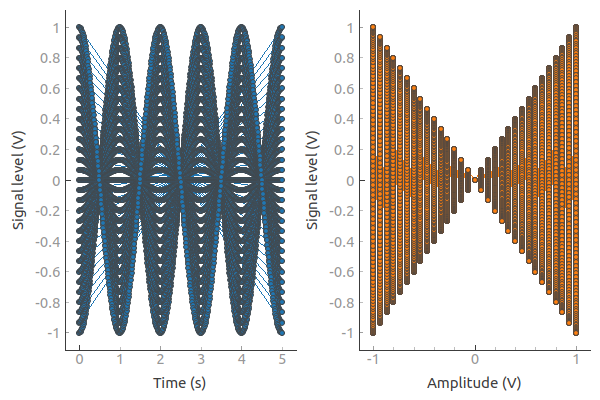

In [25]:
plotmon.main_QtPlot

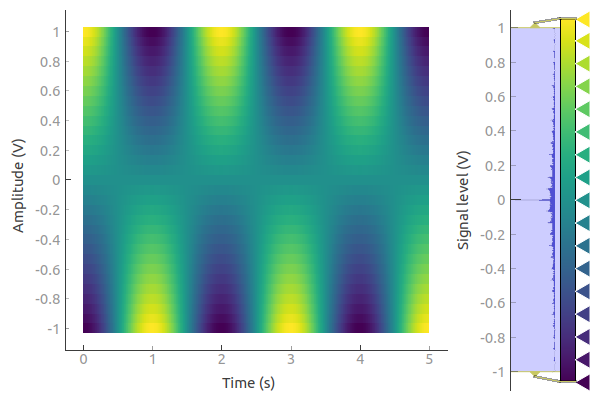

In [26]:
plotmon.secondary_QtPlot

### Method 2, custom tuples in 2D 

N.B. it is also possible to do this for higher dimensional loops

In [27]:
r = np.linspace(0, 1.5, 2000)
dt = np.linspace(0, 1, 2000)

f = 10

theta = np.cos(2*np.pi*f*dt)
def polar_coords(r, theta):

    x = r*np.cos(2*np.pi*theta)
    y = r*np.sin(2*np.pi*theta)
    return x, y 

x,y = polar_coords(r, theta)
setpoints = np.column_stack([x,y])

In [28]:
acq_delay(0.001)
MC.update_interval(0.5)

In [29]:
MC.settables([t, amp])
MC.setpoints(setpoints)
MC.gettables(sig)
dset = MC.run('2D radial setpoints')

 100% completed 	elapsed time: 10.5s 	time left: 0.0s


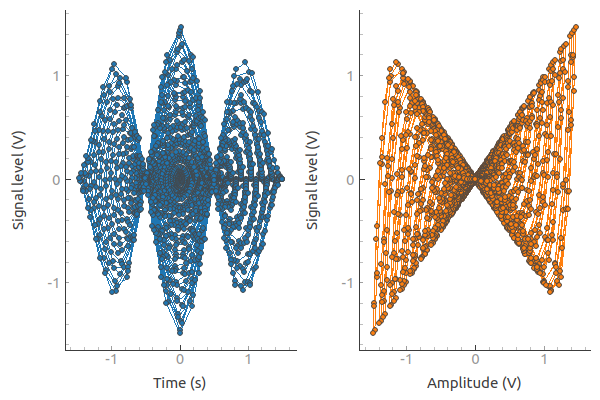

In [30]:
plotmon.main_QtPlot

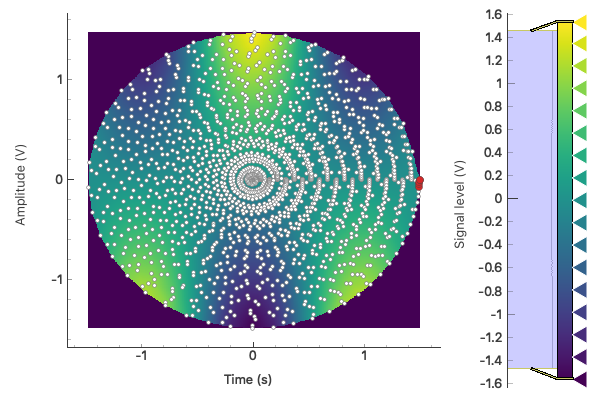

In [31]:
plotmon.secondary_QtPlot